## Merge CRSP and Compustat
The purpose of this file is to demnostrate how to merge CRSP and Compustat to map PERMNO-GVKEY pairs without CRSP-Compustat Merge table (CCM).
You should keep in mind that CCM will always give you more complete match than using CUSIP and NCUSIP.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pandasql import sqldf

pysql = lambda sql: sqldf(sql,globals())
pd.options.display.width = 180
sns.set()

### Read required data
We need the following data:
1. CRSP stock name history file
2. Compustat stock name history file
3. CRSP monthly stock file

For the first and second dataset, you can retrieve via WRDS cloud. The source is **crsp.stocknames** and **comp.security**.

### PERMNO list from CRSP monthly stock file
CRSP monthly file: this file (msf.h5) already deletes duplicates

In [2]:
msf = (pd.read_hdf('/users/ml/data/clean/wrds/msf.h5','msf',
                   columns=['permno','permco','cusip','date','ncusip','comnam','ticker','shrcd','exchcd'])
      )
msf_1 = msf.copy()
msf_1['yrm'] = (msf_1['date']/100).astype('int')
msf_permno = msf_1.drop_duplicates(subset='permno')[['permno','cusip','ncusip']]
msf_permno.columns = ['permno','msf_cusip','msf_ncusip']

### CRSP CUSIP list
stocknames file tracks the history of CRSP security. <br>
Inner join PERMNO from stocknames and PERMNO from monthly stock file. Not all PERMNOs in stocknames are included
in monthly stock file. These PERMNOs do not have any market information e.g. stock return, stock price etc., so we do not need the history of such PERMNOs.

In [3]:
stocknames = pd.read_csv('~/data/wrds/raw/stocknames.txt',sep='\t')
stocknames.columns = stocknames.columns.map(str.lower)
stocknames = stocknames.merge(msf_permno,how='inner',on='permno')

### Compustat CUSIP list
CUSIP in security file is 9-digit, so they should be converted to 8-digit. <br>
security file contains stocks listing in Canadian stock exchanges, so such stocks should be deleted. 

In [4]:
security = pd.read_csv('~/data/wrds/raw/security.txt',sep='\t')
security.columns = security.columns.map(str.lower)
security['cusip'] = security['cusip'].apply(lambda x: str(x)[:8])
security_1 = security[(security['cusip'].notnull())&(security['cusip']!='nan')&(security['excntry']=='USA')].copy()
comp_cusip = security_1.drop_duplicates(subset='cusip')[['gvkey','cusip']].sort_values('gvkey').reset_index(drop=True)

### PERMNO-GVKEY link using CUSIP 

In [5]:
stocknames_1 = stocknames[stocknames['cusip'].notnull()].copy()
crsp_cusip = (stocknames_1.drop_duplicates(subset='cusip')[['permno','cusip']].sort_values('permno')
              .reset_index(drop=True)
             )
cusip_comp_link = crsp_cusip.merge(comp_cusip,how='inner',on='cusip')
print('Number of matched PERMNO-GVKEY pair: {}'.format(len(cusip_comp_link)))

Number of matched PERMNO-GVKEY pair: 25612


### PERMNO-GVKEY link using NCUSIP 

In [6]:
stocknames_2 = stocknames[stocknames['ncusip'].notnull()].copy()
crsp_ncusip = (stocknames_2.drop_duplicates(subset='ncusip')[['permno','ncusip']].sort_values('permno')
               .reset_index(drop=True)
              )
crsp_ncusip['cusip'] = crsp_ncusip['ncusip']
del crsp_ncusip['ncusip']
ncusip_comp_link = crsp_ncusip.merge(comp_cusip,how='inner',on='cusip')

#### Demonstrate why duplicates appear
Here the CUSIP is NCUSIP, so one PERMNO-GVKEY pair may have multiple CUSIPs.

In [7]:
ncusip_comp_link_dup = ncusip_comp_link[ncusip_comp_link.duplicated(['permno','gvkey'],keep=False)]
stocknames[stocknames['permno']==10801]

,permno,permco,namedt,nameenddt,cusip,ncusip,ticker,comnam,hexcd,exchcd,siccd,shrcd,shrcls,st_date,end_date,namedum,msf_cusip,msf_ncusip
1588,10801,8695,19861031,19880504,59163C20,59163C10,MMCTA,METRO MOBILE CTS INC,2,3,4810,11,A,19861031,19920430,2,59163C20,59163C10
1589,10801,8695,19880505,19880523,59163C20,59163C10,MCTAV,METRO MOBILE CTS INC,2,3,4810,11,A,19861031,19920430,2,59163C20,59163C10
1590,10801,8695,19880524,19890208,59163C20,59163C10,MMCTA,METRO MOBILE CTS INC,2,3,4810,11,A,19861031,19920430,2,59163C20,59163C10
1591,10801,8695,19890209,19920429,59163C20,59163C20,MMZ,METRO MOBILE CTS INC,2,2,4813,11,A,19861031,19920430,2,59163C20,59163C10


In [8]:
security_1[security_1['gvkey']==12699][['tic','gvkey','iid','cusip','exchg','excntry','isin','tpci']]

,tic,gvkey,iid,cusip,exchg,excntry,isin,tpci
13478,MMZ.A,12699,01,59163C20,12.0,USA,NaN,0
13479,MMZ.B,12699,02,59163C30,12.0,USA,NaN,0
13480,MMCT,12699,03,59163C10,13.0,USA,NaN,0


#### Remove duplicated PERMNO-GVKEY pair

In [9]:
ncusip_comp_link = (ncusip_comp_link.drop_duplicates(subset=['permno','gvkey']).sort_values('permno')
                    .reset_index(drop=True)
                   )
print('Number of matched PERMNO-GVKEY pair: {}'.format(len(ncusip_comp_link)))

Number of matched PERMNO-GVKEY pair: 25902


### PERMNO-GVKEY link using CUSIP and NCUSIP 
You will miss some PERMNO-GVKEY pair if you use CUSIP only or NCUSIP only. <br>
So, the strategy is to use both CUSIP based link and NCUSIP based link to maximize the matched PERMNO-GVKEY pair. <br>
And I will show what you will miss later if you either use CUSIP only or NCUSIP only.

In [10]:
ncusip_cusip_combine = (ncusip_comp_link[['permno','gvkey']].merge(cusip_comp_link[['permno','gvkey']],
                        how='outer',on='permno')
                       )
ncusip_cusip_combine.columns = ['permno','gvkey_nc','gvkey_cc']
ncusip_cusip_combine_1 = ncusip_cusip_combine.copy()
# If there is missing PERMNO-GVKEY pair by NCUSIP, then use PERMNO-GVKEY pair based on CUSIP
ncusip_cusip_combine_1['gvkey_nc'] = (np.where(ncusip_cusip_combine_1['gvkey_nc'].isnull(),
                                     ncusip_cusip_combine_1['gvkey_cc'],ncusip_cusip_combine_1['gvkey_nc'])
                                     )
del ncusip_cusip_combine_1['gvkey_cc']
ncusip_cusip_combine_1.columns = ['permno','gvkey']
print('Number of matched PERMNO-GVKEY pair: {}'.format(len(ncusip_cusip_combine_1)))

Number of matched PERMNO-GVKEY pair: 25913


### Check missing if use CUSIP only or NCUSIP only

In [11]:
ncusip_cusip_diff = ncusip_cusip_combine[(ncusip_cusip_combine['gvkey_nc']!=ncusip_cusip_combine['gvkey_cc'])].copy()
ncusip_cusip_diff_gvkey = (ncusip_cusip_diff[(ncusip_cusip_diff['gvkey_nc'].notnull())&(ncusip_cusip_diff['gvkey_cc']
                           .notnull())].copy()
                          )

ncusip_cusip_no_nc = ncusip_cusip_diff[ncusip_cusip_diff['gvkey_nc'].isnull()].copy()
ncusip_cusip_no_cc = ncusip_cusip_diff[ncusip_cusip_diff['gvkey_cc'].isnull()].copy()

#### If you merge by CUSIP only then you will miss PERMNO-GVKEY pair in two scenarios:
After a corporate event, especially merge and aquisition, a company may chnages its name. However CRSP and Compustat have different treatments in some cases:
1. CRSP may consider they are the same firm but Compustat may consider they are different firms, so one PERMNO will match multiple GVKEYs.
2. Compustat does not have information about the firm after the event, so the CUSIP in Compustat is the CUSIP at the event time. But CRSP may contain the information of the firm after the event and update CUSIP to the lastest one.

#### Example of scenario 1

In [12]:
ncusip_cusip_diff_gvkey.head()

,permno,gvkey_nc,gvkey_cc
40,10051,13445.0,16456.0
93,10122,182437.0,17140.0
178,10238,16686.0,174114.0
194,10258,12381.0,179598.0
438,10585,12220.0,14357.0


In [13]:
stocknames[stocknames['permno']==10051]

,permno,permco,namedt,nameenddt,cusip,ncusip,ticker,comnam,hexcd,exchcd,siccd,shrcd,shrcls,st_date,end_date,namedum,msf_cusip,msf_ncusip
110,10051,7999,19860214,19890813,41043F20,81733510,SEQL,SEQUEL CORP,1,3,4830,11,NaN,19860228,20160229,2,41043F20,NaN
111,10051,7999,19890814,19901111,41043F20,41043F10,HOGG,HANGER ORTHOPEDIC GROUP INC,1,3,3840,11,NaN,19860228,20160229,2,41043F20,NaN
112,10051,7999,19901112,19910101,41043F20,41043F10,HNGR,HANGER ORTHOPEDIC GROUP INC,1,3,3840,11,NaN,19860228,20160229,2,41043F20,NaN
113,10051,7999,19910102,19910430,41043F20,41043F20,HNGR,HANGER ORTHOPEDIC GROUP INC,1,3,3840,11,NaN,19860228,20160229,2,41043F20,NaN
114,10051,7999,19910501,19981214,41043F20,41043F20,HGR,HANGER ORTHOPEDIC GROUP INC,1,2,3842,11,NaN,19860228,20160229,2,41043F20,NaN
115,10051,7999,19981215,20120613,41043F20,41043F20,HGR,HANGER ORTHOPEDIC GROUP INC,1,1,3842,11,NaN,19860228,20160229,2,41043F20,NaN
116,10051,7999,20120614,20160226,41043F20,41043F20,HGR,HANGER INC,1,1,8093,11,NaN,19860228,20160229,2,41043F20,NaN


In [14]:
security_1[security_1['gvkey']==13445][['tic','gvkey','iid','cusip','exchg','excntry','isin','tpci']]

,tic,gvkey,iid,cusip,exchg,excntry,isin,tpci
14355,SEQL.1,13445,01,81733510,13.0,USA,NaN,0


In [15]:
security_1[security_1['gvkey']==16456][['tic','gvkey','iid','cusip','exchg','excntry','isin','tpci']]

,tic,gvkey,iid,cusip,exchg,excntry,isin,tpci
17553,HNGR,16456,02,41043F20,19.0,USA,US41043F2083,0


#### Example of scenario 2

In [16]:
ncusip_cusip_no_cc.head()

,permno,gvkey_nc,gvkey_cc
53,10066,1008.0,NaN
64,10083,11947.0,NaN
522,10695,12907.0,NaN
688,10914,12842.0,NaN
1271,11725,13495.0,NaN


In [17]:
stocknames[stocknames['permno']==10066]

,permno,permco,namedt,nameenddt,cusip,ncusip,ticker,comnam,hexcd,exchcd,siccd,shrcd,shrcls,st_date,end_date,namedum,msf_cusip,msf_ncusip
146,10066,6331,19830825,19870226,35472720,00077510,ABMC,ABM COMPUTER SYS,2,3,3573,11,NaN,19830831,20020830,2,35472720,NaN
147,10066,6331,19870227,19900129,35472720,35472710,FTCO,FRANKLIN TELECOMMUNICATIONS COR,2,3,3573,11,NaN,19830831,20020830,2,35472720,NaN
148,10066,6331,19900130,19990317,35472720,35472710,NaN,FRANKLIN TELECOMMUNICATIONS COR,2,0,3573,11,NaN,19830831,20020830,2,35472720,NaN
149,10066,6331,19990318,20011114,35472720,35472720,FCM,FRANKLIN TELECOMMUNICATIONS COR,2,2,4813,11,NaN,19830831,20020830,2,35472720,NaN
150,10066,6331,20011115,20020218,35472720,35472720,FCM,FRANKLIN TELECOMMUNICATIONS COR,2,-2,7373,11,NaN,19830831,20020830,2,35472720,NaN
151,10066,6331,20020219,20020823,35472720,35472720,FCM,FRANKLIN TELECOMMUNICATIONS COR,2,2,7373,11,NaN,19830831,20020830,2,35472720,NaN


In [18]:
security_1[security_1['gvkey']==1008][['tic','gvkey','iid','cusip','exchg','excntry','isin','tpci']]

,tic,gvkey,iid,cusip,exchg,excntry,isin,tpci
8,ABMC.,1008,01,00077510,13.0,USA,NaN,0


#### If you merge by NCUSIP only then you will miss PERMNO-GVKEY pair in the following scenarios:
Sometimes, there is no valid NCUSIP for a stock in CRSP, so you can only rely on CUSIP to match such stocks.

In [19]:
ncusip_cusip_no_nc.head()

,permno,gvkey_nc,gvkey_cc
25902,10532,NaN,1764.0
25903,21899,NaN,6650.0
25904,25486,NaN,7861.0
25905,27561,NaN,1993.0
25906,31982,NaN,4866.0


In [20]:
stocknames_1[stocknames_1['permno']==10532]

,permno,permco,namedt,nameenddt,cusip,ncusip,ticker,comnam,hexcd,exchcd,siccd,shrcd,shrcls,st_date,end_date,namedum,msf_cusip,msf_ncusip
1085,10532,22199,19251231,19620701,04257310,NaN,NaN,ARNOLD CONSTABLE CORP,1,1,5310,10,NaN,19251231,19650930,2,04257310,NaN
1086,10532,22199,19620702,19650924,04257310,NaN,ACT,ARNOLD CONSTABLE CORP,1,1,5311,10,NaN,19251231,19650930,2,04257310,NaN


In [21]:
security_1[security_1['gvkey']==1764][['tic','gvkey','iid','cusip','exchg','excntry','isin','tpci']]

,tic,gvkey,iid,cusip,exchg,excntry,isin,tpci
861,1964B,1764,01,04257310,1.0,USA,NaN,0


###  Generate PERMNO-GVKEY link table using NCUSIP+CUSIP and date range

In [22]:
# If no NCUSIP, then use CUSIP to replace
num_ncusip = stocknames.groupby('permno')['ncusip'].count().to_frame('n')
num_ncusip['permno'] = num_ncusip.index
no_ncusip = num_ncusip[num_ncusip['n']==0].sort_values('permno').reset_index(drop=True)
crsp_names = stocknames.copy()
crsp_names = crsp_names.merge(no_ncusip,how='left',on='permno')
crsp_names['ncusip'] = np.where(crsp_names['n']==0,crsp_names['cusip'],crsp_names['ncusip'])
# Merge based on NCUSIP+CUSIP and corresponding date range
comp_names = security_1.copy()
comp_names['ncusip'] = comp_names['cusip']
del comp_names['cusip']
crsp_comp_names = (crsp_names[['permno','cusip','ncusip','comnam','namedt','nameenddt']]
                   .merge(comp_names[['gvkey','ncusip']],how='left',on='ncusip')
                  )
crsp_comp_names = crsp_comp_names.sort_values(['permno','namedt']).reset_index(drop=True)
crsp_comp_names['gvkey'] = crsp_comp_names.groupby('permno')['gvkey'].bfill()
crsp_comp_names = crsp_comp_names[crsp_comp_names['gvkey'].notnull()]
permno_gvkey = pysql("""select a.permno,a.cusip,a.ncusip,a.comnam,a.ticker,b.namedt,b.nameenddt,b.gvkey
                        from msf_1 a inner join crsp_comp_names b
                        on a.permno=b.permno and a.date>=b.namedt and a.date<=b.nameenddt;""")

permno_gvkey = permno_gvkey.drop_duplicates(subset=['permno','gvkey','namedt'])
permno_gvkey = permno_gvkey.sort_values(['permno','namedt']).reset_index(drop=True)

#### Check the percent of match over time
Use common stocks listing in NYSE\NASDAQ\AMEX

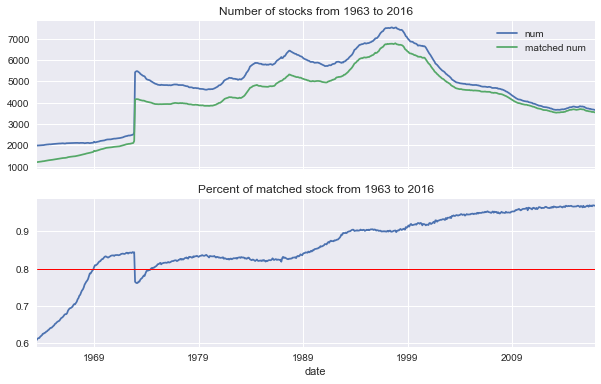

In [23]:
msf_2 = msf_1[(msf_1['shrcd'].isin([10,11]))&(msf_1['exchcd'].isin([1,2,3]))].copy()
link_ts_all = msf_2.groupby('yrm')['permno'].count().to_frame('num').sort_index()
link_ts = pysql("""select a.*
                   from msf_2 a inner join permno_gvkey b
                   on a.permno=b.permno and a.date>=b.namedt and a.date<=b.nameenddt;""")

link_ts_1 = link_ts.groupby('yrm')['permno'].count().to_frame('matched num').sort_index()
link_percent = link_ts_1.join(link_ts_all).sort_index()
link_percent = link_percent[link_percent.index>=196307]
link_percent['percent of matched stock'] = link_percent['matched num'] / link_percent['num']
link_percent.index = pd.to_datetime(link_percent.index,format='%Y%m')
link_percent.index.name = 'date'
plt.close('all')
fig1,(ax1,ax2) = plt.subplots(2,1,figsize=(10,6),sharex=True)
link_percent[['num','matched num']].plot(ax=ax1)
ax1.set_title('Number of stocks from 1963 to 2016')
link_percent['percent of matched stock'].plot(ax=ax2)
ax2.set_title('Percent of matched stock from 1963 to 2016')
ax2.axhline(0.8,color='r',linewidth=1)
plt.show()

The matched stocks are not complete, but the percent of matched is getting close to 100% in the past ten years. And most of periods can reach more than 80%.